# TMDB Movies data set analysis

IMDB is a Internet movie data base, for more information, click on https://en.wikipedia.org/wiki/IMDb / https://www.imdb.com/. 
In this project, we are considering data provided by IMDB. 

We are analyzing below points based on IMDB data.
 1. get average profit percentage and average budget of each genre
 2. get top 5 artist along with their mean profit percentage in each genre
 3. get top 5 production company along with their mean profit percentage in each genre
 4. get top 5 director along with their mean profit percentage in each genre


#### Consideration/Assumptions for the analysis

1. A movie can/will have multiple "genre, artist or production house". different "genre/artist/production house" can have  different effect on success/failure of a movie. When we say success or failure, we are talking about profit percentage.

    - In this analysis, we have not considered
     - percentage contribution of each genre of the movie in success/failure of the movie. 
     - percentage contribution of each artist of the movie in success/failure of the movie.
     - percentage contribution of each production house in success/failure of the movie. 
 
    - We have considered, if "genre/artist/production house" is part of a movie which is either successfull or failure. Profit percentage of the movie affects data used for analyis of each "genre/artist/production house" of the movie.

2. We have considered movies whose budget is atleast USD: 50,000 and revenue is atleast USD: 5,000.

3. While doing analysis on a genre, we have considered
    - Artist who has done atleast 4 movies which has the genre under investigation.
    - production house, which has produced atleast 2 movies which has the genre under investigation.
    - director who has directed atleast 2 movies which has the genre under investigation.

#### This analysis will be helpfull 
 - For an artist to consider director and production company while making new movie
 - For a director to approach successfull production comany and artists based on genres he/she is directing
 - For a production company to approach successfull artists and director based on genre

<b>Note: It is very important to understand mentioned consideration/assumptions while making use of the analysed data</b> 

In [64]:
#Import section
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [65]:
#Data reading and Wrangling

#Read data from CSV file
tmdb_movies = pd.read_csv('tmdb-movies.csv')

#Verify if there are any abnormal rows of data for columns which we are concerned
tmdb_movies.count()

id                      10866
imdb_id                 10856
popularity              10866
budget                  10866
revenue                 10866
original_title          10866
cast                    10790
homepage                 2936
director                10822
tagline                  8042
keywords                 9373
overview                10862
runtime                 10866
genres                  10843
production_companies     9836
release_date            10866
vote_count              10866
vote_average            10866
release_year            10866
budget_adj              10866
revenue_adj             10866
dtype: int64

### Data Wrangling
- Remove data which doesn't has any of the following information, since our analysis depends on these variables.
 - imdb_id 
 - cast
 - genre
 - production_companies
 - director 
- Remove movies which has release before 1990 in order to keep our analysis to recent movies

In [77]:
#Clean up data
'''
We can notice 
total row count is 10866, 
cast count is 10790, 
genres count is 10843, 
budget_adj count is 10866
revenue_adj count is 10866
imdb_id is 10856
production_companies is 9836
director is 10822
'''

# Remove rows which doesn't has imdb_id
tmdb_movies = tmdb_movies[tmdb_movies['imdb_id'].notnull()]

#find if all IMDB_id's are unique
entries = []
for entry in tmdb_movies['imdb_id']:
    if entry not in entries:
        entries.append(entry)
    else:
        print("Duplicate IMDB ID")
        print(entry)

#We can notice we have one duplicate entry with imdb_id: tt0411951. Remove this row of data which is repeated
tmdb_movies = tmdb_movies.drop_duplicates(subset=["imdb_id"], keep='first', inplace=False)

# Remove rows which doesn't has cast
tmdb_movies = tmdb_movies[tmdb_movies['cast'].notnull()]

# Remove rows which doesn't has genres
tmdb_movies = tmdb_movies[tmdb_movies['genres'].notnull()]

# Remove rows which doesn't has production_companies
tmdb_movies = tmdb_movies[tmdb_movies['production_companies'].notnull()]

# Remove rows which doesn't has director
tmdb_movies = tmdb_movies[tmdb_movies['director'].notnull()]

# Keep only movies data which has release after 1990
tmdb_movies = tmdb_movies[tmdb_movies['release_year'] > 1989]

 - verify if we see any abnormalities in budget_adj and revenue_adj and correct the data. 

In [67]:
#Describe budget_adj
tmdb_movies['budget_adj'].describe()

"""
We have atleast one record which has zero budget. 
On verifying further we can notice multiple movies whose budget is market Zero. 
Cross verifying few of these movies in wikipedia tells us these are actually not Zero budget movies.
There is some fishy about these tis
At this point we assume, TMDB doesn't have budget information of these movies, so they are marked as Zero budget movies. 
So, we will remove these movies from the dataframe based on our assumption. 
Along with these we will remove movies whose budget is less than $50,000.
Rest all stats looks fine in budget_adj
"""

tmdb_movies = tmdb_movies[tmdb_movies['budget_adj'] > 50000]

#Describe revenue_adj
tmdb_movies['revenue_adj'].describe()

'''
We can notice, revenue of atleast one movie is Zero. 
On cross verifying these movies box office revenue in Wikipedia, we can notice the revenue is not zero.
So, we are going to remove these records from dataframe, assuming IMDB doesn't has revenue records of these movies
Along with these we will remove movies whose Revenue is less than $5,000.
'''
tmdb_movies = tmdb_movies[tmdb_movies['revenue_adj'] > 5000]

 - create two new rows 
  - profit = revenue - budget
  - profit_percentage = (revenue - budget) * 100 / budget


In [68]:
#Create two new rows for profit and profit_percentage

tmdb_movies["profit"] = tmdb_movies["revenue_adj"] -tmdb_movies["budget_adj"]
tmdb_movies["profit_percentage"] = ((tmdb_movies["revenue_adj"] - tmdb_movies["budget_adj"]) * 100) / tmdb_movies["budget_adj"]

'''We will end data Wrangling process, and start data analysis from next section. Below is the final data count after data wrangling'''
tmdb_movies.count()

id                      3163
imdb_id                 3163
popularity              3163
budget                  3163
revenue                 3163
original_title          3163
cast                    3163
homepage                1330
director                3163
tagline                 2946
keywords                3050
overview                3163
runtime                 3163
genres                  3163
production_companies    3163
release_date            3163
vote_count              3163
vote_average            3163
release_year            3163
budget_adj              3163
revenue_adj             3163
profit                  3163
profit_percentage       3163
dtype: int64

##Data Analysis

Write the required functions for our analysis
 - split_by_pipe
 - display_graph
 - genre_graph_details
 - get_list_genre_dict
 - top5_per_genre_graph

In [110]:
'''
Function to split by pipe and create rows for each, for example for genres "Thriller|Crime|Drama" , 
we will have three rows of data with same value in all the fields except genre, which will have "Thriller", "Crime", "Drama" 
in diffrent rows.
'''
def split_by_pipe(df, column_name):
    header_names = list(df.columns.values)
    header_list_of_list = []
    result_df = pd.DataFrame(columns=header_names)
    for index, row in df.iterrows():
        list_by_pipe = row[column_name].split("|")
        for item in list_by_pipe:
            row_data = []
            for header in header_names:
                if header != column_name:
                    row_data.append(row[header])
                else:
                    row_data.append(item)
            result_df.loc[len(result_df)] = row_data     
    return result_df 

#Function to display graph

def display_graph(x,y):
    #display graph
    fig = plt.figure(figsize=(8, 8), dpi= 60, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(len(x)), y, 'o')
    ax1.set_xticklabels(x)
    ax1.set_xticks(np.arange(len(x)))
    plt.show()
    
#print genre name for corresponding short_name assigned to y-axis along with graph
def genre_graph_details(data):
    genres_name = pd.DataFrame()
    genres_name['full_name'] = data.index.values.tolist()
    genres_name['short_name'] = genres_name['full_name'].apply(lambda x: x[:2]).tolist()
    
    xaxis = genres_name['short_name'].tolist()
    yaxis = data.tolist()
    display_graph(xaxis,yaxis)
    
    print("Genre Names for the short form provided in graph")    
    print(genres_name)

'''
This function takes three arguments:
data: dataframe,
column_name: column name on which it operates
min_movies: minimum number of moves done on genre

The function will generate and return
List of Genres for which atleast we have five records,
Top 5 popular person/entity(artist/ production house, depnding on value passed in "column_name) for each genre
Mean profit_percentage of 5 popular person/entity for each genre

'''

def get_list_genre_dict(data, column_name, min_movies):
    result_genre_list = []
    result_genre_name_list = []
    result_genre_profit_list = []
    df_group = data.groupby("genres")
    for genre, genre_group in df_group:        
        genre_name_list = {}
        genre_profit_list = []
        artists  = genre_group.groupby(column_name)["profit_percentage"]
        artist_name_list = []
        artist_profit_list = []
        for artist, profitpercentage in artists:            
            if profitpercentage.count() >= min_movies:                
                artist_name_list.append(artist)
                artist_profit_list.append(profitpercentage.mean())
        df = pd.DataFrame()
        df[column_name] = artist_name_list
        df["profit_percentage"] = artist_profit_list
        df = df.sort_values(by=['profit_percentage'], ascending=False, inplace=False, kind='quicksort', na_position='last')
        df = df[:5]        
        genre_name_list[genre] = df[column_name].tolist()
        genre_profit_list = df["profit_percentage"].tolist()
        #If we have 5 records, append to the result
        if df["profit_percentage"].count() == 5:
            result_genre_list.append(genre)
            result_genre_name_list.append(genre_name_list)
            result_genre_profit_list.append(genre_profit_list)
    return result_genre_list, result_genre_name_list, result_genre_profit_list

#Function to display genre Graph with top 5 data
def top5_per_genre_graph(genre, data):
    genres_name = pd.DataFrame()
    genres_name['full_name'] = genre
    genres_name['short_name'] = genres_name['full_name'].apply(lambda x: x[:2]).tolist()    

    xaxis = genres_name['short_name'].tolist()
    yaxis = data
    display_graph(xaxis,yaxis) 
    
    print("Genre Names for the short form provided in graph")
    print(genres_name)

Create 3 dataframe which has
 - tmdb_split_by_genere: single genre name in genres column 
 - tmdb_split_by_genere_artist: single genre name in genres column and single artist name in cast column
 - tmdb_split_by_genere_production: single genre name in genres column and single ProductionHouse name in production_companies column


In [70]:
#split by pipe on genre to cerate additional rows of data for each genre in genres
tmdb_split_by_genere = split_by_pipe(tmdb_movies, "genres")

#split by pipe on genre to cerate additional rows of data for each genre in genres
tmdb_split_by_genere_artist = split_by_pipe(tmdb_split_by_genere, "cast")

#split by pipe on production_companies to cerate additional rows of data for each genre in genres
tmdb_split_by_genere_production = split_by_pipe(tmdb_split_by_genere, "production_companies")

## Objective 1
- Get mean profit percentage and mean budget of each genre and display it in graph 

Genre list in descending order of profit percentage


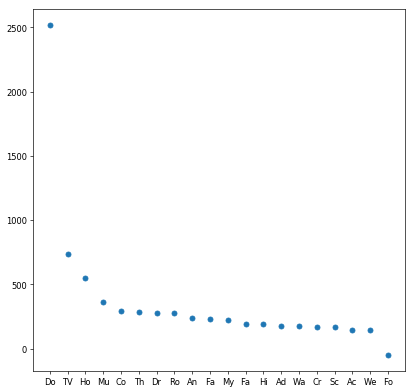

Genre Names for the short form provided in graph
          full_name short_name
0       Documentary         Do
1          TV Movie         TV
2            Horror         Ho
3             Music         Mu
4            Comedy         Co
5          Thriller         Th
6             Drama         Dr
7           Romance         Ro
8         Animation         An
9            Family         Fa
10          Mystery         My
11          Fantasy         Fa
12          History         Hi
13        Adventure         Ad
14              War         Wa
15            Crime         Cr
16  Science Fiction         Sc
17           Action         Ac
18          Western         We
19          Foreign         Fo


In [111]:
#get mean budget and profit percentage for each genre
genere_group = tmdb_split_by_genere.groupby("genres")["budget_adj", "profit_percentage"].mean()
#genere_group = genere_group.sort(['budget_adj','profit_percentage'], ascending=[False,True])



# Display graph for profit percentage of each genre
genre_profit = genere_group["profit_percentage"].sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
print("Genre list in descending order of profit percentage")
genre_graph_details(genre_profit)

Genre list in descending order of Budget


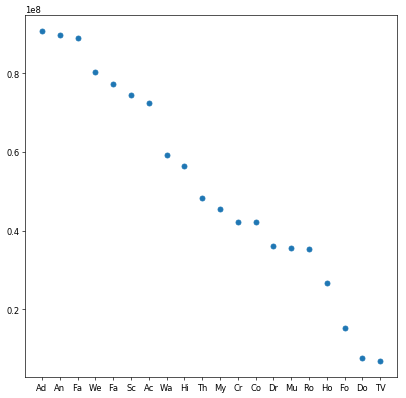

Genre Names for the short form provided in graph
          full_name short_name
0         Adventure         Ad
1         Animation         An
2           Fantasy         Fa
3           Western         We
4            Family         Fa
5   Science Fiction         Sc
6            Action         Ac
7               War         Wa
8           History         Hi
9          Thriller         Th
10          Mystery         My
11            Crime         Cr
12           Comedy         Co
13            Drama         Dr
14            Music         Mu
15          Romance         Ro
16           Horror         Ho
17          Foreign         Fo
18      Documentary         Do
19         TV Movie         TV


In [112]:
# Display graph for budget of each genre
genre_budget = genere_group["budget_adj"].sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
print("Genre list in descending order of Budget")
genre_graph_details(genre_budget)

## Objective 2
    - Get top 5 artist along with their mean profit percentage in each genre


Top 5 artists of Genre, who has done atleast 4 movies in the genre
---------------------------
Action: ['Sandra Bullock', 'Liv Tyler', 'Elijah Wood', 'Orlando Bloom', 'Viggo Mortensen']
Adventure: ['Robert Pattinson', 'Peter Facinelli', 'Ray Romano', 'Taylor Lautner', 'Liv Tyler']
Animation: ['Ray Romano', 'Denis Leary', 'Robin Williams', 'Steve Carell', 'Tom Hanks']
Comedy: ['Tom Wilkinson', 'Rowan Atkinson', 'Maggie Smith', 'Jason Lee', 'Joe Pesci']
Crime: ['Danny Glover', 'Sandra Bullock', 'Tobin Bell', 'Costas Mandylor', 'Joe Pesci']
Drama: ['John Hannah', 'Jason Lee', 'Sally Field', 'Jeremy Northam', 'Colin Firth']
Family: ["Catherine O'Hara", 'Ray Romano', 'Denis Leary', 'Daniel Radcliffe', 'Rupert Grint']
Fantasy: ['Robert Pattinson', 'Elijah Wood', 'Peter Facinelli', 'Kristen Stewart', 'Taylor Lautner']
Horror: ['Tobin Bell', 'Betsy Russell', 'Costas Mandylor', 'Sarah Michelle Gellar', 'David Koechner']
Mystery: ['Danny Glover', 'Sarah Michelle Gellar', 'Courteney Cox', 'David 

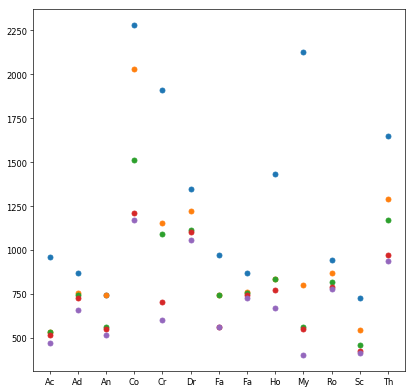

Genre Names for the short form provided in graph
          full_name short_name
0            Action         Ac
1         Adventure         Ad
2         Animation         An
3            Comedy         Co
4             Crime         Cr
5             Drama         Dr
6            Family         Fa
7           Fantasy         Fa
8            Horror         Ho
9           Mystery         My
10          Romance         Ro
11  Science Fiction         Sc
12         Thriller         Th


In [113]:
#Get top 5 artist for each genre who has performed atleast 4 movies in that particular genre
tmdb_split_by_genere_artist.count()
genre, artist, profit_percentage = get_list_genre_dict(tmdb_split_by_genere_artist, "cast", 4)

# display top 5 artists in each genre 
print("Top 5 artists of Genre, who has done atleast 4 movies in the genre")
print("---------------------------")
for g in artist:
    for key, value in g.items():
        print("{}: {}".format(key, value))
    
print("---------------------------")

#Display graph for the above data
print("Corresponding Graph in sequence of the name displayed above. Y-axis has the profit percentage of artist in sequence to name displayed above")
top5_per_genre_graph(genre,profit_percentage)


## Objective 3
    - get top 5 production company along with their mean profit percentage in each genre

Top 5 production companies of Genre, who has produced atleast 2 movies in the genre
---------------------------
Action: ['The Saul Zaentz Company', 'Tig Productions', 'Kasdan Pictures', 'Bold Films', 'Lucasfilm']
Adventure: ['Imprint Entertainment', 'Maverick Films', 'The Saul Zaentz Company', 'Temple Hill Entertainment', 'Majestic Films International']
Animation: ['Illumination Entertainment', 'Universal Pictures', 'Walt Disney Animation Australia', 'Bagdasarian Productions', 'Blue Sky Studios']
Comedy: ['Channel Four Films', 'Playtone Productions', 'Gold Circle Films', 'Silver Screen Partners IV', 'Tiger Aspect Productions']
Crime: ['Evolution Entertainment', 'Twisted Pictures', 'Channel Four Films', 'A Band Apart', 'Palace Pictures']
Drama: ['Sherwood Pictures', 'Playtone Productions', 'Provident Films', 'Affirm Films', 'Gold Circle Films']
Family: ['Hughes Entertainment', 'Illumination Entertainment', 'Heyday Films', 'Walt Disney Animation Australia', 'Silver Screen Partners IV']
F

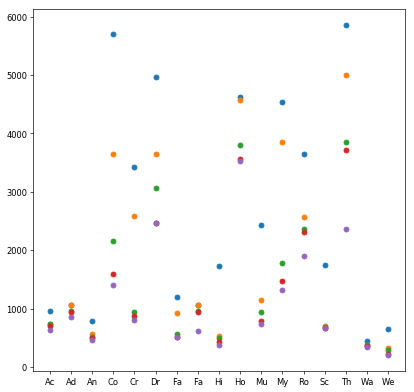

Genre Names for the short form provided in graph
          full_name short_name
0            Action         Ac
1         Adventure         Ad
2         Animation         An
3            Comedy         Co
4             Crime         Cr
5             Drama         Dr
6            Family         Fa
7           Fantasy         Fa
8           History         Hi
9            Horror         Ho
10            Music         Mu
11          Mystery         My
12          Romance         Ro
13  Science Fiction         Sc
14         Thriller         Th
15              War         Wa
16          Western         We


In [115]:
#Get top 5 production companies for each genre who has produced atleast 2 movies in that particular genre
genre, production_company, profit_percentage = get_list_genre_dict(tmdb_split_by_genere_production, "production_companies", 2)

# display top 5 artists in each genre 
print("Top 5 production companies of Genre, who has produced atleast 2 movies in the genre")
print("---------------------------")
for g in production_company:
    for key, value in g.items():
        print("{}: {}".format(key, value))
print("---------------------------")

#Display graph for the above data
print("Corresponding Graph in sequence of the name displayed above. Y-axis has the profit percentage of 'Production House' in sequence to name displayed above")
top5_per_genre_graph(genre,profit_percentage)

## Objective4
    - get top 5 director along with their mean profit percentage in each genre

Top 5 Director of Genre, who has done atleast 4 movies in the genre
---------------------------
Action: ['Peter Jackson', 'Wes Ball', 'Jay Roach', 'George Lucas', 'James Cameron']
Adventure: ['Kevin Costner', 'Chris Columbus', 'Ron Clements|John Musker', 'Chris Weitz', 'Carlos Saldanha']
Animation: ['Pierre Coffin|Chris Renaud', 'Ron Clements|John Musker', 'Carlos Saldanha', 'Gary Trousdale|Kirk Wise', 'Eric Darnell|Tom McGrath']
Comedy: ['Jared Hess', 'Peter Cattaneo', 'Jason Reitman', 'Chris Columbus', 'John Madden']
Crime: ['James Wan', 'Darren Lynn Bousman', 'Quentin Tarantino', 'Neil Jordan', 'Jay Roach']
Drama: ['John Carney', 'Alex Kendrick', 'Kevin Smith', 'Darren Aronofsky', 'Rick Famuyiwa']
Family: ['Chris Columbus', 'Pierre Coffin|Chris Renaud', 'Ron Clements|John Musker', 'Carlos Saldanha', 'David Yates']
Fantasy: ['Ron Clements|John Musker', 'Chuck Russell', 'Chris Weitz', 'Gary Trousdale|Kirk Wise', 'Bill Condon']
History: ['Steven Spielberg', 'John Madden', 'Jean-Marc Va

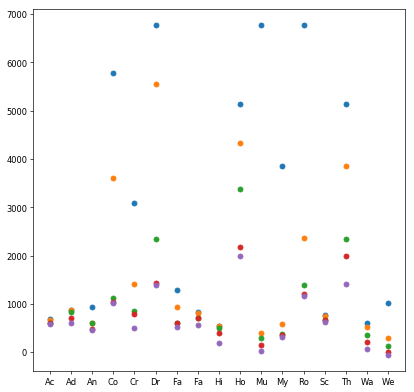

Genre Names for the short form provided in graph
          full_name short_name
0            Action         Ac
1         Adventure         Ad
2         Animation         An
3            Comedy         Co
4             Crime         Cr
5             Drama         Dr
6            Family         Fa
7           Fantasy         Fa
8           History         Hi
9            Horror         Ho
10            Music         Mu
11          Mystery         My
12          Romance         Ro
13  Science Fiction         Sc
14         Thriller         Th
15              War         Wa
16          Western         We


In [116]:
#Get top 5 director for each genre who has directed atleast 2 movies in that particular genre
tmdb_split_by_genere_artist.count()
genre, director, profit_percentage = get_list_genre_dict(tmdb_split_by_genere, "director", 2)

# display top 5 Director in each genre 
print("Top 5 Director of Genre, who has done atleast 4 movies in the genre")
print("---------------------------")
for g in director:
    for key, value in g.items():
        print("{}: {}".format(key, value))
print("---------------------------")

#Display graph for the above data
print("Corresponding Graph in sequence of the name displayed above. Y-axis has the profit percentage of Director in sequence to name displayed above")
top5_per_genre_graph(genre,profit_percentage)

## References:
 - Stackoverflow: https://stackoverflow.com
 - Wikipedia: https://www.wikipedia.org